# Chemical potential calibration
This notebook demonstrates how to use calculate salt insertion free energies from SAMS simulations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from pymbar import timeseries
from glob import glob

import sys
sys.path.append("../analysis_scripts/")
import calibration_tools as tools

Automatically process the data from the SAMS simulations

In [2]:
# Loading the calibration and automatically calibrating the chemical potential
#files = ['../sams/tip3p/out1.nc', '../sams/tip3p/out2.nc', '../sams/tip3p/out3.nc']
files = ['../calibration/wrapper_sams/tip3p/out{0}.nc'.format(i) for i in range (1,11)]
t3p = tools.AutoAnalyzeCalibration(files)

#files = ['../sams/tip4pew/out1.nc', '../sams/tip4pew/out2.nc', '../sams/tip4pew/out3.nc']
files = ['../calibration/wrapper_sams/tip4pew/out{0}.nc'.format(i) for i in range (1,11)]
t4p = tools.AutoAnalyzeCalibration(files)

The `t3p` and `t4p` objects contain a large number of statistics from the SAMS simulations. These include the free energies and average volumes necessary for the calibration of the chemical potential as well as their uncertainties.

$f(N_\text{NaCl}, N, p, T)$: The free energy to insert $N_\text{NaCl}$ salt pairs into a box of TIP4P-Ew water molecules in units of $kT$ (calculated using BAR):

In [3]:
print(t4p.cumulative_free_energy)

[    0.          -318.05881688  -634.82257946  -950.86394367 -1266.40212151
 -1581.46300874 -1896.27363003 -2210.82650563 -2525.13639012 -2839.31919345
 -3153.29282184 -3467.08768458 -3780.72288485 -4094.30848518 -4407.73750209
 -4721.06504457 -5034.27217415 -5347.36971538 -5660.4642781  -5973.41366002
 -6286.22365696]


$\langle V \rangle_{N_\text{NaCl},N,p,T}$: The average volume of a box of TIP4P-Ew waters as a function of number of salt pairs.

In [4]:
print(t4p.average_volume)

[ 26.65326186  26.57516119  26.50819146  26.42635379  26.35226623
  26.28321964  26.21192966  26.14517528  26.07064659  26.0028541
  25.93875589  25.8740586   25.80615134  25.74497627  25.6817803
  25.61816119  25.55529656  25.49149181  25.43560961  25.36694893
  25.30741158]


We use the free energy to insert the first salt pair to calculate the hydration free energy of NaCl.

In [5]:
# The hydration free energy of water in kcal/mol:
hyd_water = -6.4  

# kT in kcal/mol:
kT = 300 * 0.00192

print('TIP3P salt insertion free energy in = {0:.1f} +/- {1:.1f} kcal/mol'.format(t3p.cumulative_free_energy[1]*kT,2*t3p.error_free_energy[0]*kT))
print('TIP4P-Ew salt insertion free energy in = {0:.1f} +/- {1:.1f} kcal/mol'.format(t4p.cumulative_free_energy[1]*kT, 2*t4p.error_free_energy[0]*kT))

print('\nTIP3P Hydration free energy of NaCl = {0:.1f} +/- {1:.1f} kcal/mol'.format(t3p.cumulative_free_energy[1]*kT - 2 *hyd_water, 2*t4p.error_free_energy[0]*kT))
print('TIP4P-Ew Hydration free energy of NaCl = {0:.1f} +/- {1:.1f} kcal/mol'.format(t4p.cumulative_free_energy[1]*kT - 2 *hyd_water, 2*t4p.error_free_energy[0]*kT))

TIP3P salt insertion free energy in = -184.3 +/- 0.0 kcal/mol
TIP4P-Ew salt insertion free energy in = -183.2 +/- 0.0 kcal/mol

TIP3P Hydration free energy of NaCl = -171.5 +/- 0.0 kcal/mol
TIP4P-Ew Hydration free energy of NaCl = -170.4 +/- 0.0 kcal/mol


Joung and Cheatham calculated the hydration free energy of Na$^+$ and Cl$^-$ seperately in TIP3P and TIP4P-Ew water. These can be summed to produce an estimates of the hydratation free energy of NaCl.

**TIP3P**: -88.7 kcal/mol (Na$^+$ ) - 89.6 kcal/mol (Cl$^-$) = -178.3 kcal/mol

**TIP4P-Ew**: -88.4 kcal/mol (Na$^+$ ) - 89.3 kcal/mol (Cl$^-$) = -177.7 kcal/mol

## Comparison of free energies calculated with SAMS and BAR
The SAMS free energies have a much higher variance than the values calculated with BAR. The below compares the free energies calculated with BAR (over all simulations) compared to the individual SAMS estimates.

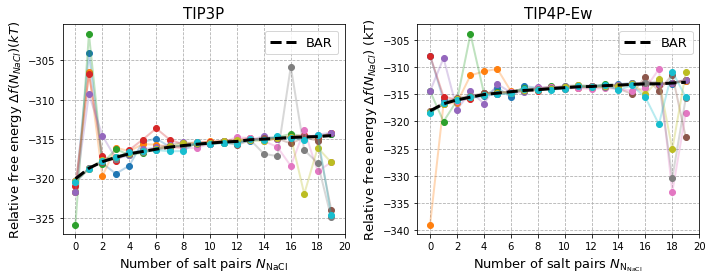

In [64]:
FONTSIZE=13
ALPHA=0.3

fig, ax = plt.subplots(1,2, figsize=(10,4))

# TIP3P
for i in range(len(t3p.sams)):
    ax[0].plot(-np.diff(t3p.sams[i]), 'ro', color='C{0}'.format(i))
    ax[0].plot(-np.diff(t3p.sams[i]), lw=2, color='C{0}'.format(i), alpha=ALPHA)
ax[0].plot(t3p.relative_free_energy, lw=3, color='black', label='BAR', ls='--')

ax[0].set_xticks(range(0,int(np.max(t3p.nsalt))+1,2))
ax[0].set_title('TIP3P', fontsize=15)
ax[0].set_xlabel('Number of salt pairs $N_\mathrm{NaCl}$', fontsize=FONTSIZE)
ax[0].set_ylabel('Relative free energy $\Delta f(N_{NaCl}) (kT)$', fontsize=FONTSIZE)
ax[0].legend(fontsize=FONTSIZE)
ax[0].grid(ls='--')
#ax[0].set_xlim(0,20)


# TIP4P-Ew
for i in range(len(t4p.sams)):
    ax[1].plot(-np.diff(t4p.sams[i]), 'ro', color='C{0}'.format(i))
    ax[1].plot(-np.diff(t4p.sams[i]), lw=2, color='C{0}'.format(i), alpha=ALPHA)
ax[1].plot(t4p.relative_free_energy, lw=3, color='black', label='BAR', ls='--')
ax[1].set_xticks(range(0,int(np.max(t3p.nsalt))+1,2))
ax[1].set_title('TIP4P-Ew', fontsize=15)
ax[1].set_xlabel('Number of salt pairs $N_\mathrm{N_{NaCl}}$', fontsize=FONTSIZE)
ax[1].set_ylabel('Relative free energy $\Delta f(N_{NaCl})$ (kT)', fontsize=FONTSIZE)
ax[1].legend(fontsize=FONTSIZE)
ax[1].grid(ls='--')
#ax[1].set_xlim(0,20)

plt.tight_layout()
plt.savefig('BAR_SAMS_comparison.png', dpi=300)
plt.show()

The different colored lines are for each SAMS repeat (10 in total for each water model). The reason why the SAMS estimates have such high variance is because each SAMS run failed to sample uniformally over salt numbers. The cells below show this for TIP3P.

In [ ]:
# Loading the individual SAMS simulations for TIP3P:
DIR = "../calibration/wrapper_sams/tip3p/"
files = [DIR + 'out{0}.nc'.format(r) for r in range(1,11)]

nsalt = []
for f in files:
    ncfile = Dataset(f)
    nspecies = ncfile.groups['Sample state data']['species counts']
    nsalt.append(nspecies[:,1])
    ncfile.close()

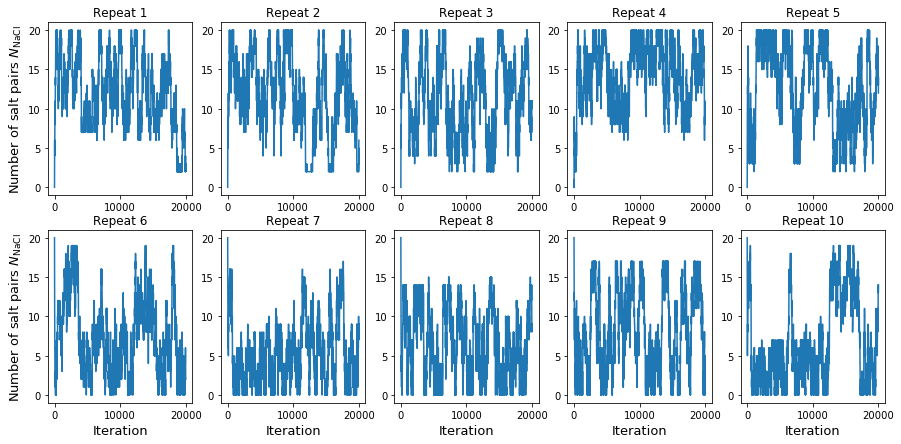

In [65]:
fig, ax = plt.subplots(2, 5, figsize=(15,7))
k = 0
for i in range(0,2):
    for j in range(0,5):
        ax[i,j].plot(nsalt[k])
        ax[i,j].set_title('Repeat {0}'.format(k+1))
        k +=1
ax[0,0].set_ylabel('Number of salt pairs $N_\mathrm{NaCl}$', fontsize=13)
ax[1,0].set_ylabel('Number of salt pairs $N_\mathrm{NaCl}$', fontsize=13)
[ax.set_xlabel('Iteration', fontsize=13) for ax in ax[1,:]]
#plt.tight_layout()
plt.show()

Half of the simulations started with the maximum of 20 salt pairs already inserted, whereas the other half started with 0 salt pairs. The initial guess of the free energies for adding salt was close to the true value. So, as the SAMS simulations began, the initial states accumulated too much weight, effectively locking the sampler into the the latter states.